<a href="https://colab.research.google.com/github/qmeng222/MNIST-Playground/blob/main/missing_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task:

---
*   Purpose: explore how a trained DL model behaves when it's presented with images that it has never seen (trained) before.
*   Methodology:
    1.  Train the MNIST-FFN model on all nums expect 7s (the test dataset is all 7s).
    2.  Test on 7s, and observe how the model behaves to never-seen images.

In [41]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [42]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',') # numpy array

# extract labels, then drop labels from data:
labels = data[:,0] # extract 1st col
data   = data[:,1:] # drop

# normalize (both train & test) data (including the 7s):
dataNorm = data / np.max(data)

In [43]:
# convert to PyTorch tensors:
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()
print("dataT shape:", dataT.shape)
print("labelsT shape:", labelsT.shape, "\n")

# separate the tensors into 7s and non-7s:
where7 = labels==7 # bool flag
data7     = dataT[where7,:] # for test only
dataNo7   = dataT[~where7,:]
labelsNo7 = labelsT[~where7]

# confirm that the separation is accurate:
np.unique(labelsNo7)

dataT shape: torch.Size([20000, 784])
labelsT shape: torch.Size([20000]) 



array([0, 1, 2, 3, 4, 5, 6, 8, 9])

In [44]:
# PyTorch tensors -> PyTorch TensorDataset objects:
# combine data and label tensors into a single dataset object
train_data = TensorDataset(dataNo7,labelsNo7) # train on all nums expect 7s
test_data  = TensorDataset(data7) # test all 7s
print(train_data.tensors[0].shape)
print(test_data.tensors[0].shape)

# PyTorch TensorDataset objects -> PyTorch dataloader objects:
# shuffle the data to help model generalize better
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

torch.Size([17874, 784])
torch.Size([2126, 784])


In [45]:
for batch in test_loader: # only one batch
    print(batch)
    print("-------")

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])]
-------


In [46]:
def createTheMNISTNet():

  # model class:
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10) # NOTE: still 10 outputs, but output #7 is never trained

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 ) # log-softmax is needed for NLLLoss (negative log likelihood loss)

  # create a model instance:
  net = mnistNet()

  # loss function:
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [47]:
# a function that trains the model (anything test-related can be deleted!)

def function2trainTheModel():

  # number of epochs
  numepochs = 100

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []

  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
  # end epochs

  # function output
  return trainAcc,losses,net

In [48]:
# run the function to train the model (wo/ 7s):
trainAcc,losses,net = function2trainTheModel()

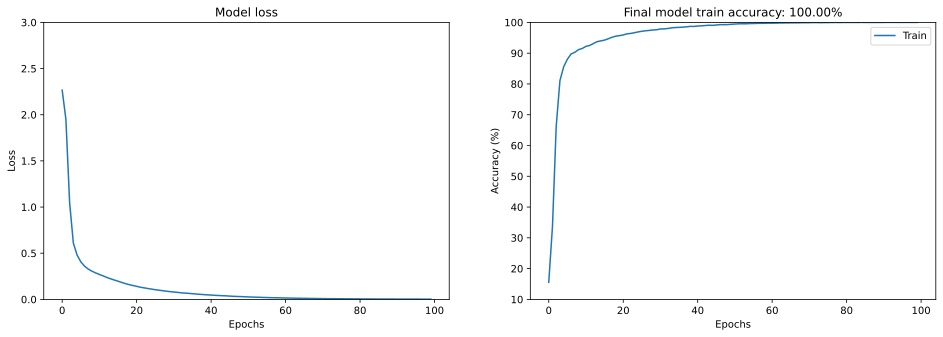

In [49]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

👆 The model is still performing really well even without the 7s included.

# **Test with unseen 7s:**

In [50]:
# run the model through for the test data
X = next(iter(test_loader))[0] # only extract X(,y) from test dataloader, bc we don't need the labels here
predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions,axis=1).detach()

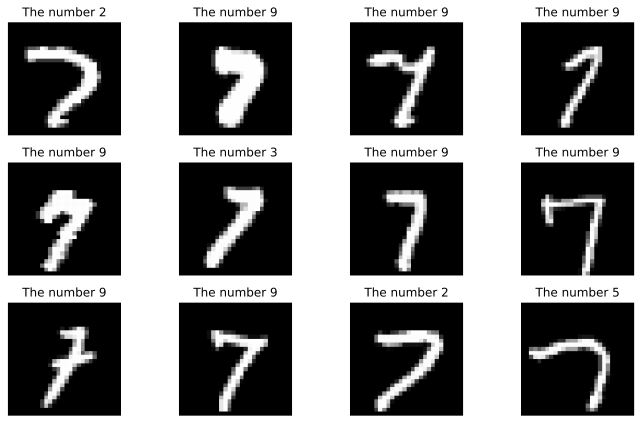

In [51]:
# show some 7's and their labels

fig,axs = plt.subplots(3,4,figsize=(10,6))

someRandom7s = np.random.choice(len(X),12)

for i,ax in enumerate(axs.flatten()):

  thisimg = X[ someRandom7s[i] ].view(28,28)
  ax.imshow(thisimg,cmap='gray')
  ax.set_title(f'The number {guesses[ someRandom7s[i] ]}')
  ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


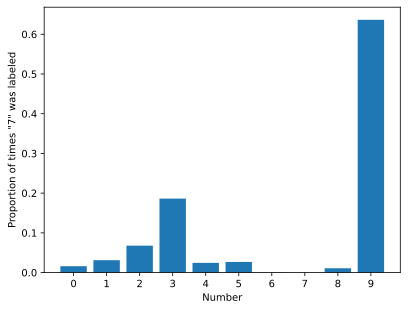

In [52]:
# which numbers are most likely to be confused with 7?
print( np.unique(guesses) )

probMistaken = np.zeros(10)

for i in range(10):
  probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10),probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

👆The model displays a tendency to misinterpret the number 7 as 9 in the majority of cases. Additionally, it occasionally misinterprets the number 3 and the number 2 as well.

In [55]:
print(predictions.shape) # 2126 test images
predictions

torch.Size([2126, 10])


tensor([[-1.8697e+00, -3.1982e+01, -1.7566e+01,  ..., -1.9477e+01,
         -1.0463e+01, -1.6761e-01],
        [-1.4447e+01, -2.9410e+01, -1.5304e+01,  ..., -2.6256e+01,
         -1.6415e+01, -8.3446e-07],
        [-2.0577e+01, -2.1521e+01, -7.1731e+00,  ..., -2.8189e+01,
         -1.7141e+01, -8.8783e-04],
        ...,
        [-1.1648e+01, -9.3049e+00, -1.1630e+00,  ..., -1.4709e+01,
         -9.8721e+00, -2.0632e+00],
        [-1.4776e+01, -7.3379e+00, -8.3942e+00,  ..., -1.6553e+01,
         -8.8798e+00, -4.8445e-03],
        [-1.1512e+01, -4.6156e+00, -9.1492e-01,  ..., -1.3842e+01,
         -4.4192e+00, -1.0337e+00]])

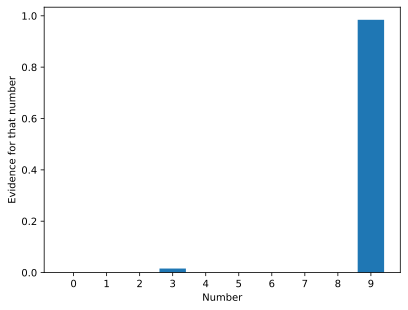

In [56]:
# evidence for all numbers from one sample
sample2show = 22

plt.bar(range(10),torch.exp(predictions[sample2show])) # exp(log-softmax) to get the probabilities
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.show()